In [106]:
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input
from keras.preprocessing.text import Tokenizer

In [107]:
max_words = 20
batch_size = 32
epochs = 5

In [108]:
import pandas
df_train = pandas.read_csv("data/train.csv")
df_test = pandas.read_csv("data/test.csv")
df_val = pandas.read_csv("data/val.csv")

In [109]:
df_train.head()

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


In [110]:
print("Preparing the Tokenizer...")
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_train["text"])

Preparing the Tokenizer...


In [111]:
print('Vectorizing sequence data...')
x_train = tokenizer.texts_to_matrix(df_train["text"], mode='binary')
x_test = tokenizer.texts_to_matrix(df_test["text"], mode='binary')
x_val = tokenizer.texts_to_matrix(df_val["text"], mode='binary')
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Vectorizing sequence data...
x_train shape: (181467, 20)
x_test shape: (22684, 20)


In [112]:
x_train

array([[ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  1.,  0.]])

In [113]:
print('Convert class vector to binary class matrix '
      '(for use with categorical_crossentropy)')
num_classes = 2
y_train = keras.utils.to_categorical(df_train["class"], num_classes)
y_val = keras.utils.to_categorical(df_val["class"], num_classes)
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)

Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train shape: (181467, 2)
y_val shape: (22683, 2)


In [114]:
y_val

array([[ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       ..., 
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.]])

In [115]:
print('Building model sequentially 1...')
model = Sequential()
model.add(Dense(16, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

Building model sequentially 1...


In [116]:
print('Building model sequentially 2...')
model = Sequential([
          Dense(16, input_shape=(max_words,)),
          Activation('relu'),
          Dense(num_classes),
          Activation('softmax')
        ])

Building model sequentially 2...


In [117]:
model.layers

In [118]:
print(model.to_yaml())

backend: tensorflow
class_name: Sequential
config:
- class_name: Dense
  config:
    activation: linear
    activity_regularizer: null
    batch_input_shape: !!python/tuple [null, 20]
    bias_constraint: null
    bias_initializer:
      class_name: Zeros
      config: {}
    bias_regularizer: null
    dtype: float32
    kernel_constraint: null
    kernel_initializer:
      class_name: VarianceScaling
      config: {distribution: uniform, mode: fan_avg, scale: 1.0, seed: null}
    kernel_regularizer: null
    name: dense_15
    trainable: true
    units: 16
    use_bias: true
- class_name: Activation
  config: {activation: relu, name: activation_15, trainable: true}
- class_name: Dense
  config:
    activation: linear
    activity_regularizer: null
    bias_constraint: null
    bias_initializer:
      class_name: Zeros
      config: {}
    bias_regularizer: null
    kernel_constraint: null
    kernel_initializer:
      class_name: VarianceScaling
      config: {distribution: uniform, m

In [119]:
print('Building model functionally...')
a = Input(shape=(max_words,))
b = Dense(16)(a)
b = Activation('relu')(b)
b = Dense(num_classes)(b)
b = Activation('softmax')(b)
model = Model(inputs=a, outputs=b)

Building model functionally...


In [120]:
from keras.models import model_from_yaml

yaml_string = model.to_yaml()
model = model_from_yaml(yaml_string)

In [121]:
! pip install pydot-ng

In [122]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

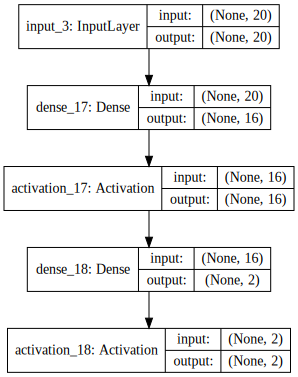

In [123]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [124]:
from keras.objectives import categorical_crossentropy
from keras import backend as K

epsilon = 1.0e-9
def custom_objective(y_true, y_pred):
    '''Yet another crossentropy'''
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
    y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
    cce = categorical_crossentropy(y_pred, y_true)
    return cce

In [125]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [126]:
model.compile(loss=custom_objective,
              optimizer='adam',
              metrics=['accuracy'])

In [127]:
from keras.callbacks import TensorBoard  
tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
from keras.callbacks import EarlyStopping  
early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

Train on 163320 samples, validate on 18147 samples
Epoch 1/5
163320/163320 [==============================] - 14s - loss: 6.8747 - acc: 0.5818 - val_loss: 6.6867 - val_acc: 0.5870
Epoch 2/5
163320/163320 [==============================] - 13s - loss: 6.6954 - acc: 0.5863 - val_loss: 6.6778 - val_acc: 0.5859
Epoch 3/5
163320/163320 [==============================] - 13s - loss: 6.6778 - acc: 0.5870 - val_loss: 6.6618 - val_acc: 0.5881
Epoch 4/5
163320/163320 [==============================] - 15s - loss: 6.6680 - acc: 0.5876 - val_loss: 6.6697 - val_acc: 0.5870


In [128]:
score = model.evaluate(x_val, y_val, batch_size=batch_size, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

21088/22683 [==========================>...] - ETA: 0s

Test score: 6.65468605022
Test accuracy: 0.587752942746


In [129]:
results = model.predict(x_test, batch_size=batch_size, verbose=1)

20352/22684 [=========================>....] - ETA: 0s

In [130]:
prediction = df_test.copy()
prediction["class"] = pandas.Series(results[:,1])

In [131]:
prediction[["id", "class"]].to_csv("data/submission.csv", index=False)